# TP9 - Quasi Monte-Carlo and LH Sampling
Eliott Van Dieren - epfl

In [103]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import math
from sobol_new import *

## 1. Approximating integral using CMC, LHS and QMC

Here, we want to approximate $\int_{[0,1]^d}f(x)dx = \mathbb{E}[f(x)]$ with $x \sim U([0,1]^d)$

<ol>
    <li>CMC : Generate $X^{(i)} \sim U([0,1]^d)$ for $i \in {1,...,N}$, then compute the empirical mean of $f(X)$ to get $\hat{\mu}_{CMC}$</li>
    <li>LHS : Generate N iid pairs $U^{(i)} \sim U([0,1]^d)$, then $d$ independant permutations $\pi_j$ and set $\pi^{(i)} = (\pi_1^{(i)},...,\pi_d^{(i)}) \in \mathbb{R}^d$. Finally, set $X^{(i)}=\frac{1}{N}(\pi^{(i)}-1+U^{(i)}) \in \mathbb{R}^d$. Goal : compute $\mathbb{E}[f(X)]$, by estimating it : $\hat{\mu}_{LHS} = \frac{1}{N}\sum_{i=1}^Nf(X^{(i)})$. A final step is to repeat those $K$ times to get the average of this estimator</li>
    <li>QMC : Creating a low discrepancy sequence of points using Sobol sequence generator, then compute $\hat{\mu}_{QMC} = \frac{1}{N}\sum_{i=1}^N f(X)$ where $X \in \mathbb{R}^d$. Then repeat that $K$ times and do a Monte-Carlo averaging on this to get $\hat{\hat{\mu}}_{QMC}$ (useful to use CLT for confidence intervals, etc.
</ol>

In [127]:
d=2
N_vals = np.arange(500,50001,1000)

# Thanks Noah

def OscillatoryFunction(x,d,w=1/2):
    c = 9/d
    return np.cos(2*np.pi*w + c*np.sum(x))
 
def SolOscillatoryFunction(d, w = 1/2):
    c = 9/d
    return np.real(np.exp(1j*2*np.pi*w)*(1/(1j*c)*(np.exp(1j*c)-1))**d)

def ProductPeak(x,d,w=1/2):
    c = 7.25/d
    return np.prod((c**(-2)+(x-w)**2)**(-1))

def SolProductPeak(d,w=1/2):
    c = 7.25/d
    return (c*np.arctan(c*(1-w))+np.arctan(c*w))**d
    
def Gaussian(x,d,w=1/2):
    c = 7.03/d
    return np.exp(-np.sum((c*(x-w))**2))

def SolGaussian(d, w = 1/2):
    c = 7.03/d
    return (np.sqrt(np.pi)/(2*c)*(math.erf(c*(1-w))+math.erf(c*w)))**d

def ContinuousFunction(x, d, w = 1/2):
    c = 2.04/d
    return np.exp(-np.sum(c*np.abs(x-w)))

def SolContinuousFunction(d, w = 1/2):
    c = 2.04/d
    return (1/c*(2-np.exp(-c*w)-np.exp(-c*(1-w))))**d

def DiscontinuousFunction(x, d, w1 = np.pi/4, w2 = np.pi/5):
    c = 4.3/d
    return (x[0]<=w1 and x[1]<=w2)*np.exp(np.sum(c*x))

def SolDiscontinuousFunction(d, w1 = np.pi/4, w2 = np.pi/5):
    # c parameter, has to stay one dimensional
    c = 4.3/d
    return ((np.exp(c)-1)**(-2)/c)**d*(np.exp(c*w1)-1)*(np.exp(c*w2)-1)

def VolumeSimplex(x,d):
    return (np.sum(x)<=1)

def SolVolumeSimplex(d):
    # d dimensions
    return 1/math.factorial(d)    

In [139]:
# CMC
func_names = ["osc","prod","gauss","cont","disc","vol"]
func = [OscillatoryFunction,ProductPeak,Gaussian,ContinuousFunction,DiscontinuousFunction,VolumeSimplex]
sol_func = [SolOscillatoryFunction,SolProductPeak,SolGaussian,SolContinuousFunction,SolDiscontinuousFunction,SolVolumeSimplex]

mu_MC = {}
for idx,func_name in enumerate(func_names):
    mu_MC[func_name] = np.zeros((len(N_vals),2))
for idx_n,n in enumerate(N_vals):
    X = st.uniform.rvs(size=n*d).reshape(n,d)
    simulations_MC = np.zeros((len(func),n))
    for idx,func_name in enumerate(["osc","prod","gauss","cont","disc","vol"]):
        simulations_MC[idx] = [func[idx](X[i],d) for i in range(n)]
        mu_MC[func_name][idx_n] = [np.mean(simulations_MC[idx]),1.96*np.std(simulations_MC[idx])/sqrt(n)]

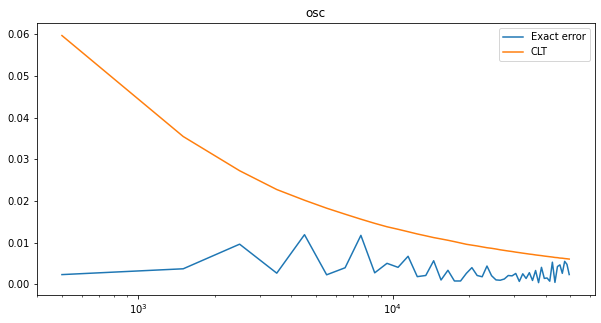

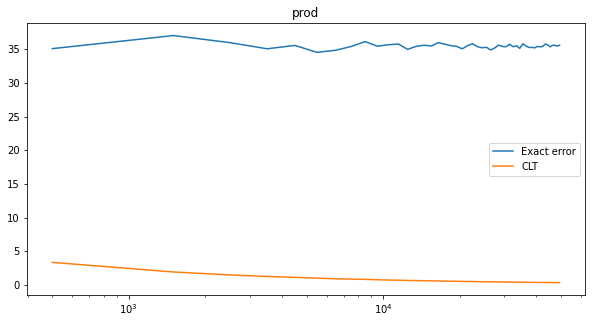

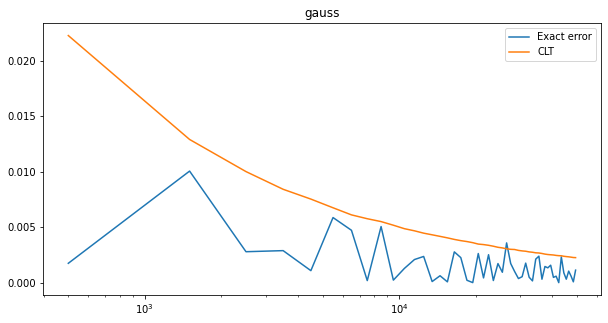

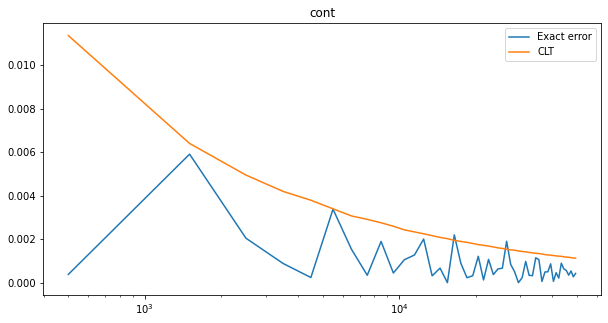

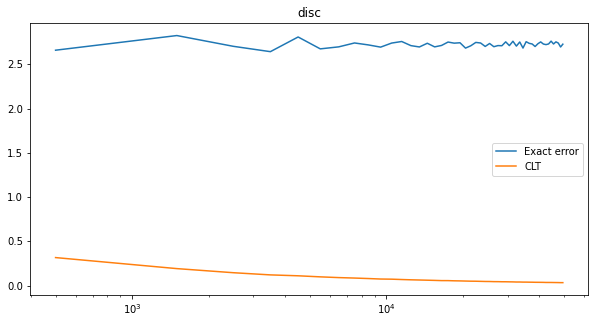

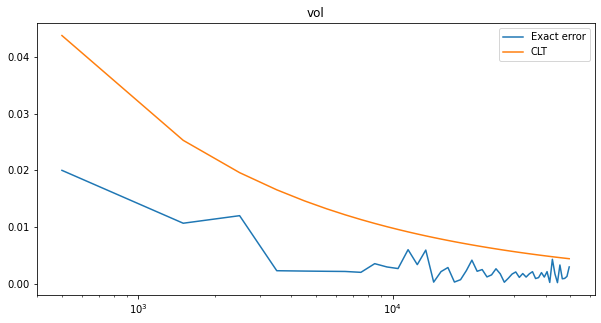

In [140]:
for idx,fun_name in enumerate(func_names):
    plt.figure(figsize=(10,5))
    plt.plot(N_vals,np.abs(mu_MC[fun_name][:,0]-sol_func[idx](d)),label="Exact error")
    plt.plot(N_vals,mu_MC[fun_name][:,1],label="CLT")
    plt.xscale("log")
    plt.title(fun_name)
    plt.legend()
    plt.show()

In [145]:
# LHS
mu_LHS_avg = {}
K = 10

for idx,func_name in enumerate(func_names):
    mu_LHS_avg[func_name] = np.zeros((len(N_vals),2))
    
for idx_n,n in enumerate(N_vals):
    for func_name in func_names:
        mu_LHS[func_name] = np.zeros(K)
    for _ in range(K):
        pi = np.array([np.random.permutation(n) for i in range(d)])
        U = st.uniform.rvs(size=n*d).reshape(d,n)
        X = ((pi+U)/n).T
        simulations_LHS = np.zeros((6,n))
        for idx,func_name in enumerate(func_names):
            simulations_LHS[idx] = [func[idx](X[i],d) for i in range(n)]
            mu_LHS[func_name][_] = np.mean(simulations_LHS[idx])
    for idx,func_name in enumerate(func_names):
        mu_LHS_avg[func_name][idx_n] = [np.mean(mu_LHS[func_name]),1.96*np.std(mu_LHS[func_name])/sqrt(K)]

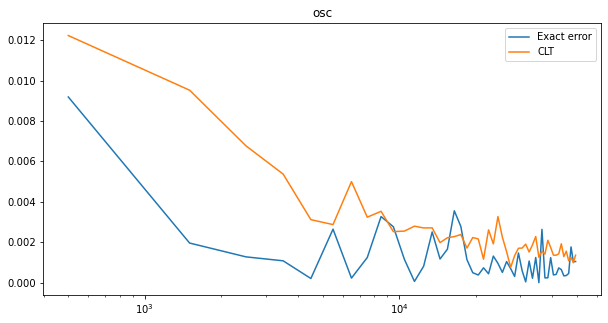

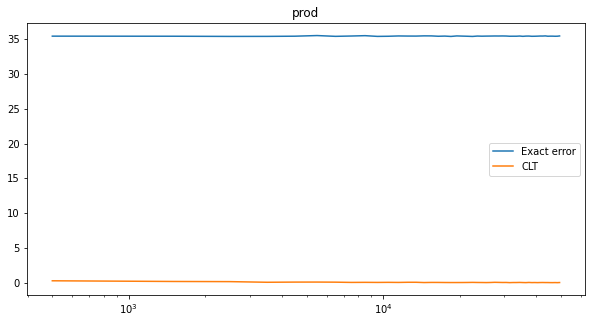

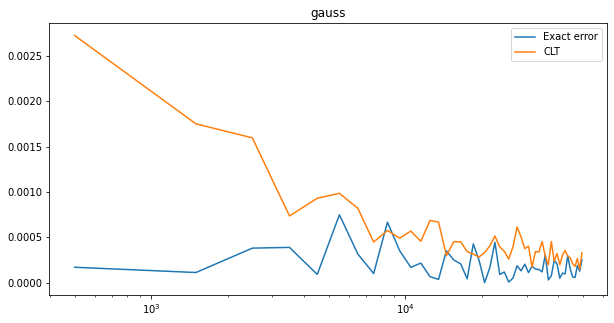

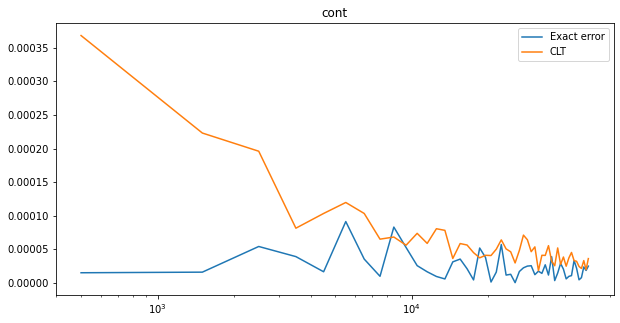

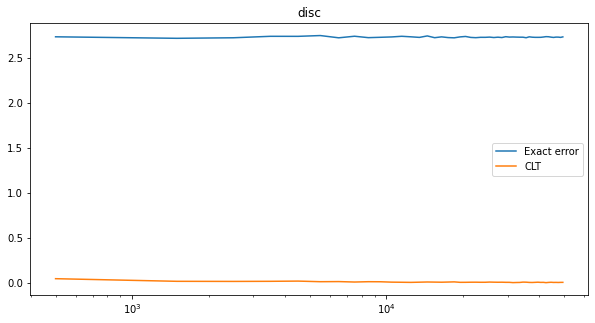

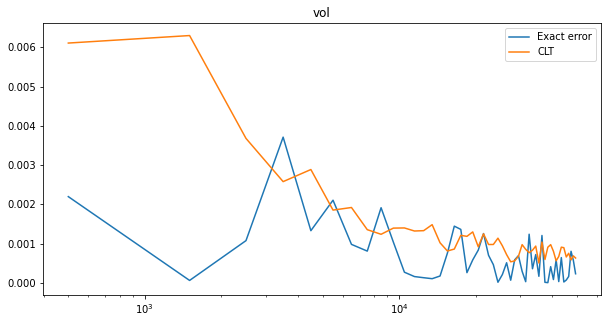

In [146]:
for idx,fun_name in enumerate(func_names):
    plt.figure(figsize=(10,5))
    plt.plot(N_vals,np.abs(mu_LHS_avg[fun_name][:,0]-sol_func[idx](d)),label="Exact error")
    plt.plot(N_vals,mu_LHS_avg[fun_name][:,1],label="CLT")
    plt.xscale("log")
    plt.title(fun_name)
    plt.legend()
    plt.show()

In [105]:
# QMC
X = generate_points(N,d,0)
mu_QMC_avg = {}
for func_name in func_names:
    mu_QMC_avg[func_name] = 0
K = 10
for _ in range(K):
    simulations_QMC = np.zeros((6,N))
    for idx,func_name in enumerate(["osc","prod","gauss","cont","disc","vol"]):
        simulations_QMC[idx] = [func[idx](X[i],d) for i in range(N)]
        mu_QMC_avg[func_name] += np.sum(simulations_QMC[idx])/N

for func_name in func_names:
    mu_QMC_avg[func_name] /= K
print(mu_QMC_avg)

{'osc': 0.02520931416108311, 'prod': 59.800287644901786, 'gauss': 0.24773512903123654, 'cont': 0.6136246642125741, 'disc': 2.7304144793571212, 'vol': 0.5002300000000001}


In [147]:
# same method

## 2. Estimating yet another integral
Check correction, should be more or less the same method